#### *Analyze a family of RNNs all trained on the same data but with different hyperparameters.*

Essentially, most RNNs fit the muscle activity data (EMG) with almost the same loss.

(This is a very easy task from an ML standpoint.)

But not all such RNNs are equivalent as RNNs are overparametrized, and their internal behavior depends on hyperparameters. Here we investigate this dependence.

The cost function for the RNN
$$ \sum_{t,c}\|\hat{y}(t,c) - y(t,c)\|_2^2 + \lambda_1\|A\|_F^2 + \lambda_2\|C\|_F^2,$$
where $A$ and $C$ are the state-to-state and state-to-output matrices, respectively.

The RNN hyperparameters,
- $\lambda_1$
- $\lambda_2$
- $\sigma_w$ (std dev of noise injected into neurons during training

are compared against various measures of RNN activation trajectories
- mean curvature
- mean curvature (path length normalized)
- mean torsion (generalized curvature)
- trajectory "tangling" (a "global measure of curvature")
- path length
- dimensionality (participation ratio)
- average of the norms of the Jacobian evaluated at all path points
- "noise robustness"
- "structural robustness"

The latter two measures are obtained by resimulating the RNN and injecting noise to the state variables (noise robustness) or by adding a random perturbation to $A$ (structural robustness) and then finding the strength of noise required to drop the EMG fit to $R^2< 0.5$. This is tricky because a small perturbation in $A$ can result in EMG fits that are *qualitiatively* good but *quantitatively* bad (e.g. small frequency changes might result in a huge drop in $R^2$). Thus we use dynamic time warping (DTW) as a measure of loss instead of $MSE$ or $R^2$---first apply DTW then take $R^2$. This minor details turns out to actually make a difference.

----------

### TODO
Do:
- [DONE] Test for 1 condition only
- Lie stuff -- lie bracket, lie derivatives, etc
- regularize the RNN activations maybe
- [DONE] normalize by path length for curvature calculations
- [DONE] check to make sure dtw is working correctly
- plot ref lines for M1 data


# 0. Initial stuff

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import scipy.io as sio
import sklearn as sk

from sklearn import decomposition
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf

# For jupyter tensorboarding
from io import BytesIO
from functools import partial
import PIL.Image
from ipywidgets import FloatProgress

from IPython.display import clear_output, Image, display, HTML

import pickle
import os
import pprint as pp

from dtw import dtw
from cdtw import pydtw

from tqdm import tqdm # progress bar

In [4]:
import cyclingrnn.geometric as geo
from cyclingrnn import sigerr
from cyclingrnn.train import *

In [5]:
# sns colormaps
cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
sns.set_palette(cmap)
sns.set_context('paper', font_scale=1.5)

In [6]:
RUN = '../saves/170215D/'

In [7]:
# process directory information
data_files = [i for i in os.listdir(RUN+'npsaves/') if i.endswith('x.npy')]
sim_nums = [i.replace('x.npy', '') for i in data_files]
param_files = [i+'params.pickle' for i in sim_nums]
assert len(data_files) == len(param_files)

total_sims = len(data_files)
print 'total sims: ', total_sims

total sims:  1000


In [147]:
data_files = [i for i in os.listdir(RUN+'npsaves/') if i.endswith('x.npy')]
sim_nums = [i.replace('x.npy', '') for i in data_files]
param_files = [i+'params.pickle' for i in sim_nums]
assert len(data_files) == len(param_files)

total_sims = len(data_files)





# Number of sims in RUN
# Get monkey
cur_params = pickle.load(open(RUN+'npsaves/'+param_files[0], 'rb'))
# build input and output data
if cur_params['monkey']=='D':
  data = sio.loadmat('../drakeFeb_processed.mat')
else:
  data = sio.loadmat('../cousFeb_processed.mat')


In [150]:
[int(i) for i in sim_nums]

[1000,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 10,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 11,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 12,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 13,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 14,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 15,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 16,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 17,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 18,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 19,
 1,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 20,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 21,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 22,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 23,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 24,
 250,
 251,
 2

In [149]:
sim_nums

['1000params.pickle',
 '100params.pickle',
 '101params.pickle',
 '102params.pickle',
 '103params.pickle',
 '104params.pickle',
 '105params.pickle',
 '106params.pickle',
 '107params.pickle',
 '108params.pickle',
 '109params.pickle',
 '10params.pickle',
 '110params.pickle',
 '111params.pickle',
 '112params.pickle',
 '113params.pickle',
 '114params.pickle',
 '115params.pickle',
 '116params.pickle',
 '117params.pickle',
 '118params.pickle',
 '119params.pickle',
 '11params.pickle',
 '120params.pickle',
 '121params.pickle',
 '122params.pickle',
 '123params.pickle',
 '124params.pickle',
 '125params.pickle',
 '126params.pickle',
 '127params.pickle',
 '128params.pickle',
 '129params.pickle',
 '12params.pickle',
 '130params.pickle',
 '131params.pickle',
 '132params.pickle',
 '133params.pickle',
 '134params.pickle',
 '135params.pickle',
 '136params.pickle',
 '137params.pickle',
 '138params.pickle',
 '139params.pickle',
 '13params.pickle',
 '140params.pickle',
 '141params.pickle',
 '142params.pick

In [140]:
RUN

'../saves/170208C/'

In [138]:
# Number of sims in RUN
total_sims = len([i for i in os.listdir(RUN+'mlsaves') if i!='.DS_Store'])


# Visualize results

In [125]:
df_path = '../saves/170208D/df0123.pickle'
df = pickle.load(open(df_path))

In [126]:
df = df[df['activation'] == 'tanh']

In [127]:
df = df[df['R2'] > 0.5]

In [128]:
# Display columns
df.columns

Index([u'activation', u'beta1', u'beta2', u'monkey', u'num_neurons',
       u'rnn_init', u'stddev_out', u'stddev_state', u'MSE', u'R2',
       u'noise_robustness', u'path_length', u'percent_tangling1',
       u'percent_tangling2', u'percent_tangling3', u'struct_robustness',
       u'mean_curvature', u'mean_torsion'],
      dtype='object')

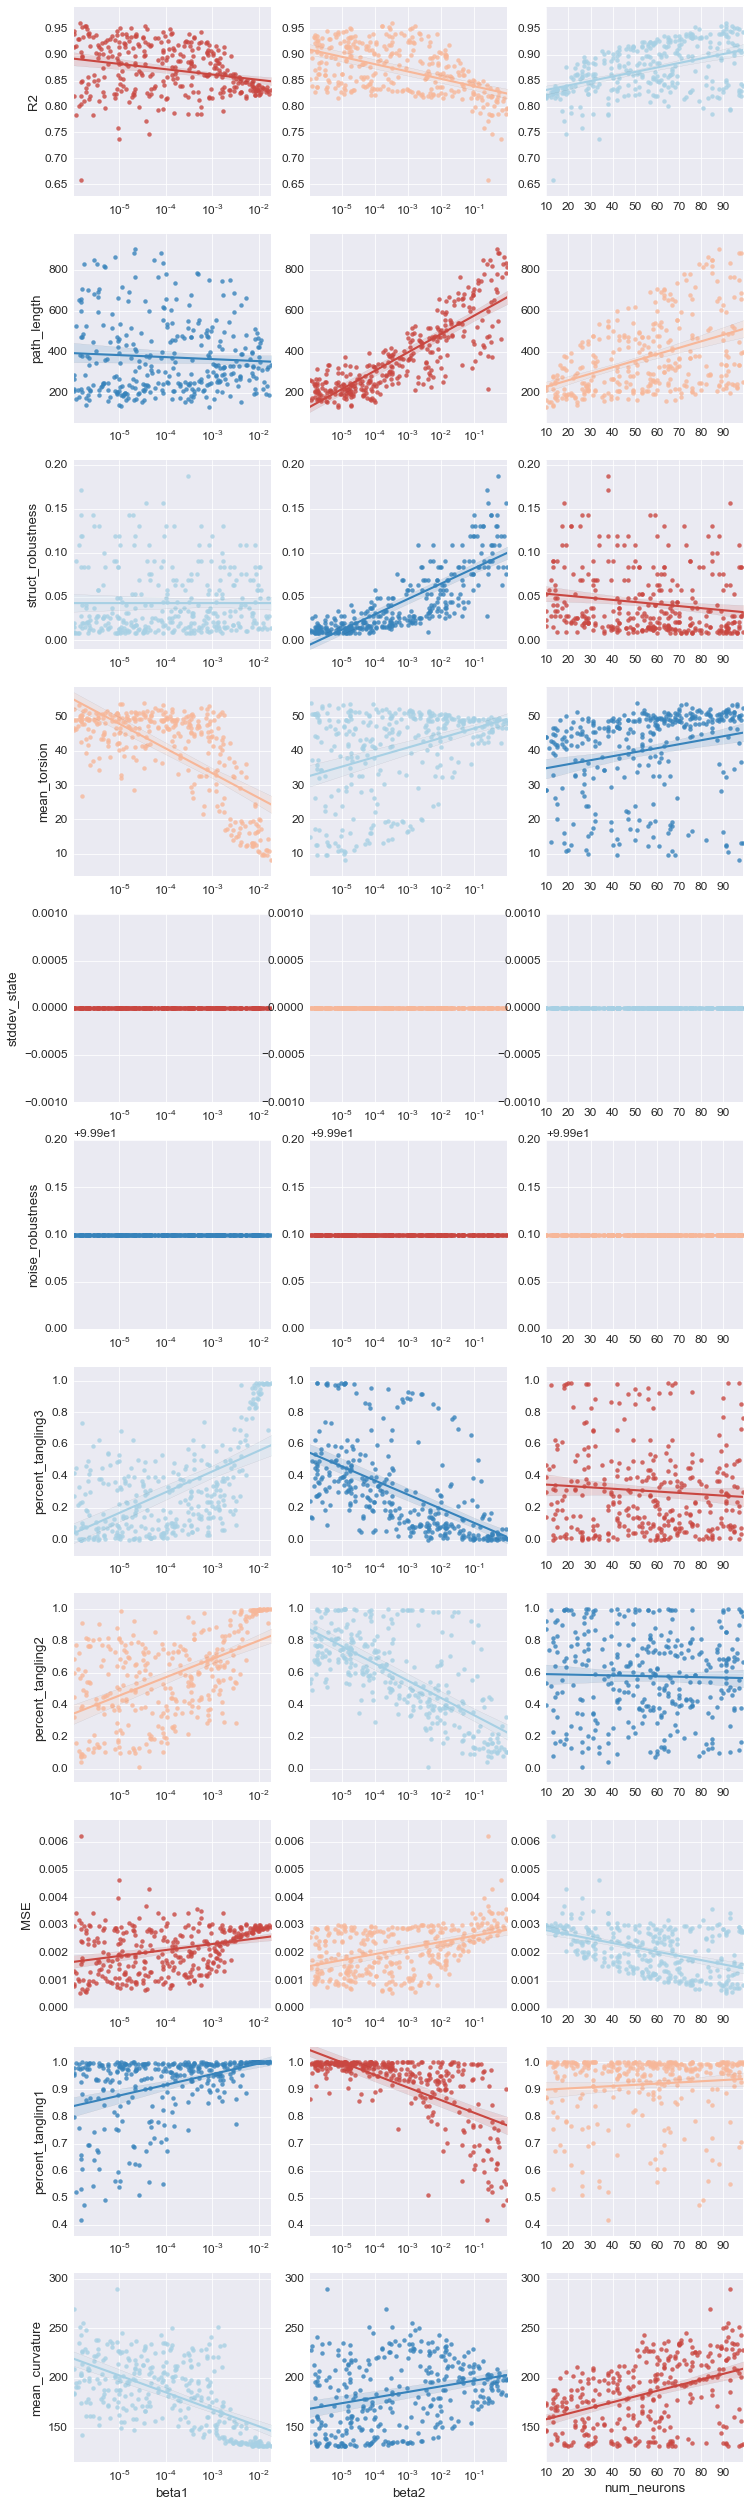

In [129]:
cols = [u'beta1', u'beta2',  u'num_neurons'] # hyperparameters of the model
exclude = [u'monkey', u'activation', u'stddev_out', u'rnn_init'] # exclude these
rows = list(set(df.columns) - set(cols) - set(exclude)) # everything else
logx = [u'beta1', u'beta2', u'stddev_state'] # which cols get a log xscale

num_cols = len(cols)
num_rows = len(rows)

fact = 4
f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols,fact*num_rows), sharey=False, sharex=False)

for ir, row in enumerate(rows):
  for ic, col,  in enumerate(cols):
    logx_bool = col in logx
    if logx_bool:
      ax[ir, ic].set_xscale('log', basex=10)
    sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
    if ir < num_rows-1:
      ax[ir, ic].xaxis.label.set_visible(False)
    if ic > 0:
      ax[ir, ic].yaxis.label.set_visible(False)
      
    d_range = df[row].max() - df[row].min()
    ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
    ax[ir, ic].set_xlim([df[col].min(), df[col].max()])
      
plt.show()

In [132]:
df.columns

Index([u'activation', u'beta1', u'beta2', u'monkey', u'num_neurons',
       u'rnn_init', u'stddev_out', u'stddev_state', u'MSE', u'R2',
       u'noise_robustness', u'path_length', u'percent_tangling1',
       u'percent_tangling2', u'percent_tangling3', u'struct_robustness',
       u'mean_curvature', u'mean_torsion'],
      dtype='object')

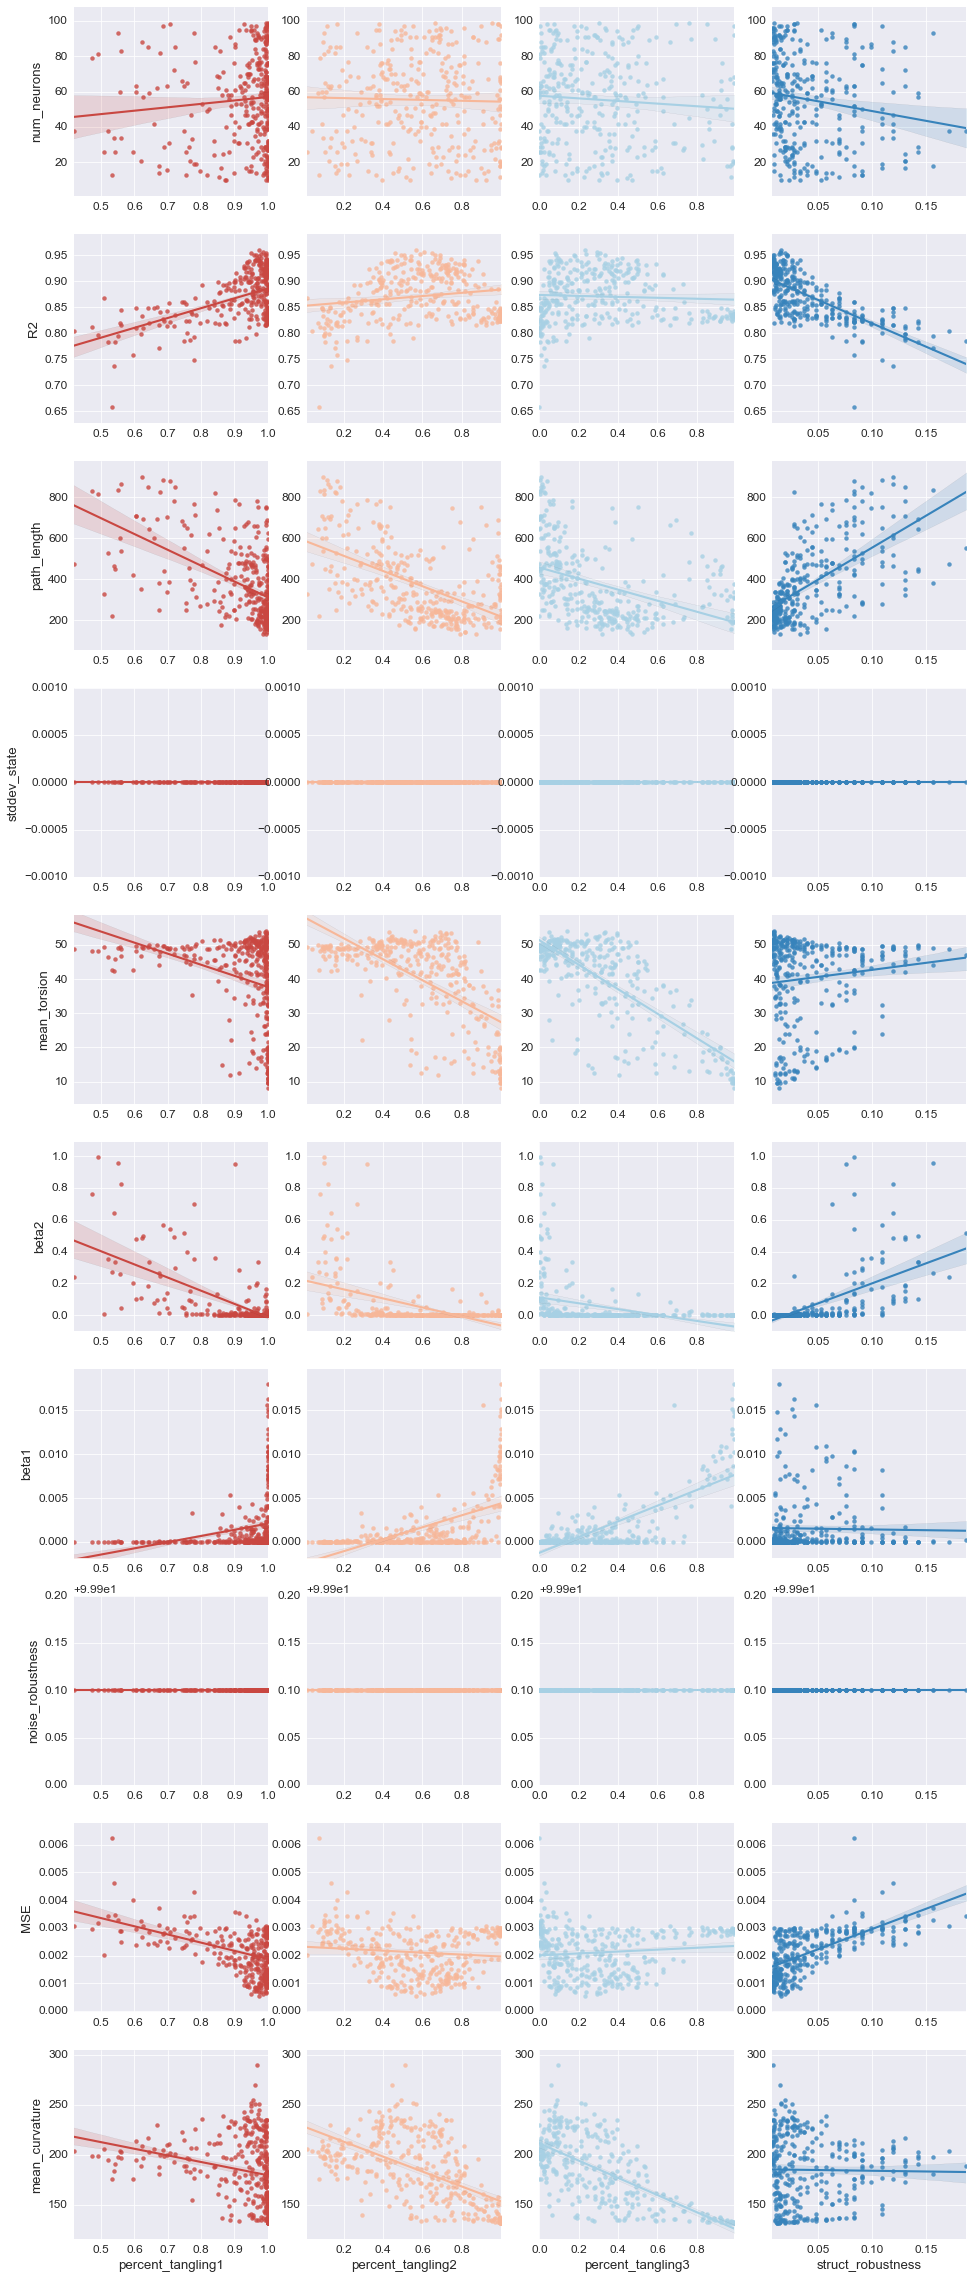

In [135]:
cols = ['percent_tangling1', 'percent_tangling2', 'percent_tangling3', 'struct_robustness'] # hyperparameters of the model
exclude = [u'monkey', u'activation', u'stddev_out', u'rnn_init'] # exclude these
rows = list(set(df.columns) - set(cols) - set(exclude)) # everything else
logx = [u'beta1', u'beta2', u'stddev_state'] # which cols get a log xscale

num_cols = len(cols)
num_rows = len(rows)

fact = 4
f, ax = plt.subplots(num_rows, num_cols, figsize=(fact*num_cols,fact*num_rows), sharey=False, sharex=False)

for ir, row in enumerate(rows):
  for ic, col,  in enumerate(cols):
    logx_bool = col in logx
    if logx_bool:
      ax[ir, ic].set_xscale('log', basex=10)
    sns.regplot(col, row, df, logx=logx_bool, ax=ax[ir, ic], truncate=False)
    if ir < num_rows-1:
      ax[ir, ic].xaxis.label.set_visible(False)
    if ic > 0:
      ax[ir, ic].yaxis.label.set_visible(False)
      
    d_range = df[row].max() - df[row].min()
    ax[ir, ic].set_ylim([df[row].min()-0.1*d_range, df[row].max()+0.1*d_range])
    ax[ir, ic].set_xlim([df[col].min(), df[col].max()])
      
plt.show()

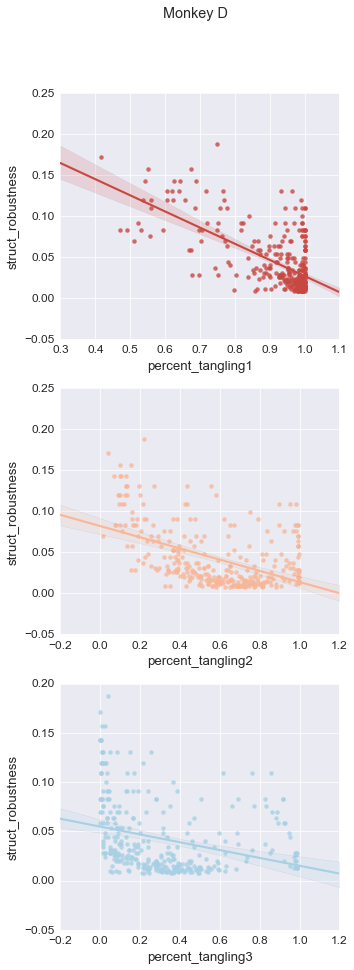

In [131]:
f, ax = plt.subplots(3, 1, figsize=(5,15))
f.suptitle('Monkey '+df.monkey.iloc[0])
sns.regplot('percent_tangling1', 'struct_robustness', df, ax=ax[0])
sns.regplot('percent_tangling2', 'struct_robustness', df, ax=ax[1])
sns.regplot('percent_tangling3', 'struct_robustness', df, ax=ax[2])

In [113]:
for i_struct, stddev_struct in enumerate(np.logspace(-2.1, 1, num=80)):
  print stddev_struct

0.00794328234724
0.00869441780928
0.00951658240734
0.0104164928236
0.0114015008855
0.0124796536265
0.0136597590266
0.0149514579691
0.0163653030018
0.0179128445462
0.0196067252591
0.0214607833162
0.0234901654642
0.0257114507614
0.0281427860209
0.0308040340613
0.0337169359759
0.0369052887468
0.0403951396551
0.0442149990737
0.0483960733836
0.0529725199145
0.0579817259935
0.0634646143814
0.0694659775915
0.0760348438225
0.0832248774948
0.0910948176627
0.0997089578837
0.109137671465
0.11945798638
0.130754214547
0.14311864062
0.156652275904
0.171465683574
0.187679881914
0.205427332987
0.224853024777
0.246115655673
0.269388930959
0.294862981896
0.322745919007
0.353265532235
0.386671151873
0.423235685478
0.463257847384
0.507064599054
0.5550138202
0.607497232478
0.664943599667
0.727822230455
0.796646812467
0.871979608835
0.954436051617
1.04468976957
1.14347809138
1.25160806926
1.36996307218
1.49951000256
1.64130719538
1.79651306426
1.96639556517
2.15234255495
2.35587312944
2.57865003377
2.822493

In [110]:
np.unique(df['struct_robustness'])

array([ 0.00794328,  0.00869442,  0.00951658,  0.01041649,  0.0114015 ,
        0.01247965,  0.01365976,  0.01495146,  0.0163653 ,  0.01791284,
        0.01960673,  0.02146078,  0.02349017,  0.02571145,  0.02814279,
        0.03080403,  0.03371694,  0.03690529,  0.04039514,  0.044215  ,
        0.04839607,  0.05297252,  0.05798173,  0.06346461,  0.06946598,
        0.07603484,  0.08322488,  0.09109482,  0.09970896,  0.10913767,
        0.11945799,  0.13075421,  0.14311864,  0.15665228,  0.17146568,
        0.18767988])

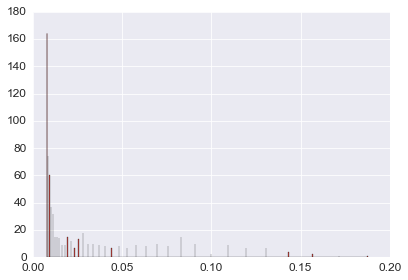

In [109]:
plt.hist(df['struct_robustness'], bins=1000)
plt.show()

In [47]:
from cyclingrnn.train import *

def get_full_data(cur_params):
  """
    returns u_data, y_data for tensorflow's feed_dict.
  """
  path_prefix = '../'
  if cur_params['monkey']=='D':
    data = sio.loadmat(path_prefix+'drakeFeb.mat')
  else:
    data = sio.loadmat(path_prefix+'cousFeb.mat')

  # Built augmented data
  emg2 = preprocess_array(data['D'][0, 0]['EMG'])
  time_axis, time_inds1, time_inds2 = get_time_axis(data['D'][0, 0]['KIN'])
  y_data1 = emg2[time_axis]
  p = y_data1.shape[-1]

  # Build inputs
  m = 2
  u_data1 = create_input_array(y_data1.shape)

  # Augmented data
  # For regularizing the network -- it must fit actual and augmented data
  period = int(np.round(np.diff(time_inds2).mean()))
  y_cat1 = augmented_data(emg2, time_inds1, period=period, tiles=10)
  y_cat1 = y_cat1[::25]
  y_cat2 = augmented_data(emg2, time_inds2, period=period, tiles=10)
  y_cat2 = y_cat2[::25]

  u_cat1 = create_input_array(y_cat1.shape)
  u_cat2 = create_input_array(y_cat2.shape)

  sequence_length = [y_data1.shape[0], y_cat1.shape[0], y_cat2.shape[0]]
  y_data = np.zeros((np.max(sequence_length), 4*3, p))
  u_data = np.zeros((np.max(sequence_length), 4*3, m))

  y_data[:sequence_length[0], 0:4, :] = y_data1
  y_data[:sequence_length[1], 4:8, :] = y_cat1
  y_data[:sequence_length[2], 8:12, :] = y_cat2

  u_data[:sequence_length[0], 0:4, :] = u_data1
  u_data[:sequence_length[1], 4:8, :] = u_cat1
  u_data[:sequence_length[2], 8:12, :] = u_cat2
  return u_data, y_data

In [57]:
from pprint import pprint

In [68]:
def get_noise_sim(stddev_struct, stddev_state, RUN, sim, y_data, u_data):
  """
    loads TF model. Then simulates it again, but with noise
    stddev_struct: std dev of structural perturbation on weight matrix
    stddev_state: std dev of additive noise to each neuron
    RUN: directory of the current run
    sim: integer for the simulation
    y_data, u_data: reference data for feed_dict
  """
  TF_PATH = RUN+'tfsaves/'+str(sim)
  tf.reset_default_graph()
  with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(TF_PATH+'.meta')
    new_saver.restore(sess, TF_PATH)
    # Get Mat variable
    Mat = sess.run([v for v in tf.global_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'][0])
    A = Mat[2:]
    B = Mat[:2]
    #pprint([n.name for n in tf.get_default_graph().as_graph_def().node])
    newMat = np.zeros(Mat.shape)
    newMat[:2] = B
    newMat[2:] = A + stddev_struct*np.random.randn(A.shape[0], A.shape[1])
    sess.run([v for v in tf.global_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'][0].assign(newMat))
    feed_dict = {'Y:0': y_data, 'U:0': u_data, 'stddev_state:0': stddev_state}
    y_hat, x_hat = sess.run(['Y_hat:0', 'RNN_1/TensorArrayPack_1/TensorArrayGatherV2:0'], feed_dict)
  return y_hat, x_hat

In [69]:
cur_params = {}

In [70]:
cur_params['monkey'] = 'D'

In [71]:
u_data, y_data = get_full_data(cur_params)

In [73]:
y, x = get_noise_sim(0, 0, '../saves/170208D/', 1, y_data, u_data)

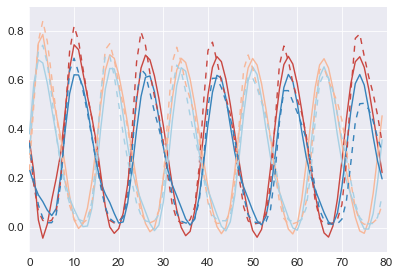

In [96]:
n = 10
c = range(4)
plt.plot(y[:80,c,n])
plt.plot(y_data[:80,c,n],'--')
plt.show()